In [58]:
import sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


In [59]:
#Load the txt file and make the date and time columns as index
df = pd.read_csv('./input/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date','Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [60]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
#Resample the dataset to mean
df = df.resample('H').mean()

In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [7]:
#loading column names into a list. Comes handy when visualizing forecasting
columnarray = list(df.columns)

In [8]:
df.isnull().sum()

Global_active_power      421
Global_reactive_power    421
Voltage                  421
Global_intensity         421
Sub_metering_1           421
Sub_metering_2           421
Sub_metering_3           421
dtype: int64

In [9]:
#removing Nan values. It is replaced with the column mean
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [10]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [13]:
#this function converts the series data to supervised data. Remember, we use [n_in timesteps of previous data] to predict [n_out steps for future data]
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [15]:
timesteps=30 #Using 30 previous timesteps ==> 1 timestep is one hour
n_features=7 # We are predicting n_features of data. This corresponds to multi-parallel time series forecasting problem
values = df_resample.values 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(values.shape)

# frame as supervised learning
reframed = series_to_supervised(scaled, timesteps, 1)

# drop columns we don't want to predict
# reframed.drop(reframed.columns[-6:], axis=1, inplace=True) ==> Use this to predict only 1 column (var1 ie Global active power)
print(reframed)

(34589, 7)
       var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30       0.636816    0.295738    0.337945    0.631157         0.0    0.011366   
31       0.545045    0.103358    0.335501    0.541487         0.0    0.144652   
32       0.509006    0.110073    0.283802    0.502152         0.0    0.030869   
33       0.488550    0.096987    0.315987    0.481110         0.0    0.000000   
34       0.455597    0.099010    0.434417    0.449904         0.0    0.008973   
...           ...         ...         ...         ...         ...         ...   
34584    0.140459    0.118898    0.566977    0.137733         0.0    0.017588   
34585    0.058375    0.119113    0.664672    0.061215         0.0    0.009332   
34586    0.036080    0.061214    0.643624    0.038020         0.0    0.000000   
34587    0.027447    0.072191    0.731844    0.027738         0.0    0.000000   
34588    0.032471    0.141713    0.770186    0.032879         0.0    0.016870   

       var7(t-30

In [16]:
values = reframed.values
print(values.shape)
n_obs = n_features*timesteps
n_train_time = 365*24*2 #Training 2 years of data for training
train = values[:n_train_time, :]
test = values[n_train_time:, :]
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features:]
#When given train_X[0] it should predict train_Y[0]
test_X, test_y = test[:, :n_obs], test[:, -n_features:]
# reshape input to be 3D [samples, timesteps, features] ==> A very key concept in LSTM training
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps,n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 


(34559, 217)
(17520, 30, 7) (17520, 7) (17039, 30, 7) (17039, 7)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
#The input shape must be timesteps, n_features. That way, It takes one list item of n_in timesteps of n_features columns
#to predict one future timestep
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=10, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 17520 samples, validate on 17039 samples
Epoch 1/10
17520/17520 [==============================] - 30s 2ms/sample - loss: 0.0215 - val_loss: 0.0153
Epoch 2/10
17520/17520 [==============================] - 27s 2ms/sample - loss: 0.0157 - val_loss: 0.0143
Epoch 3/10
17520/17520 [==============================] - 29s 2ms/sample - loss: 0.0146 - val_loss: 0.0138
Epoch 4/10
17520/17520 [==============================] - 32s 2ms/sample - loss: 0.0142 - val_loss: 0.0136
Epoch 5/10
17520/17520 [==============================] - 33s 2ms/sample - loss: 0.0139 - val_loss: 0.0135
Epoch 6/10
17520/17520 [==============================] - 32s 2ms/sample - loss: 0.0137 - val_loss: 0.0132
Epoch 7/10
17520/17520 [==============================] - 33s 2ms/sample - loss: 0.0135 - val_loss: 0.0131
Epoch 8/10
17520/17520 [==============================] - 34s 2ms/sample - loss: 0.0132 - val_loss: 0.0131
Epoch 9/10
17520/17520 [==============================] - 34s 2ms/sample - loss: 0.0131 - val_

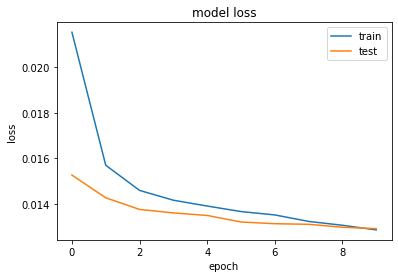

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:

# make a prediction
yhat = model.predict(test_X)
print(yhat.shape)
inversed_values = scaler.inverse_transform(yhat) # Important note here is that scaler is fitted with columns seven.
#Since yhat has shape with 7 columns, it does fine. If we are predicting only one column, then we may need to concatenate 
#that column with 6 other random columns ( usual convention : test_X last six columns is used to concatenated) and 
#inverse transformed, and take out the first column ie our output
# inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
#use inv_yhat[0] for output

test_y = test_y.reshape((len(test_y), 7))
# inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


(17039, 7)
Test RMSE: 0.114


# Visualization of Predicted values

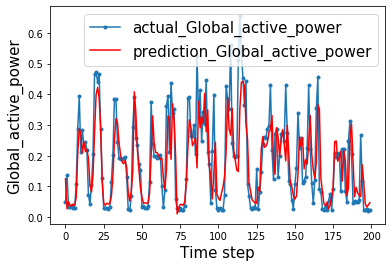

In [26]:
aa=[x for x in range(200)]
y=0
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

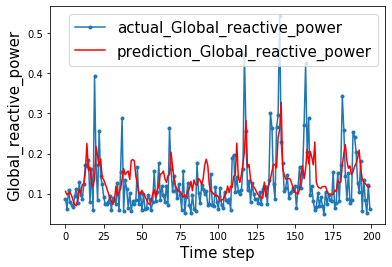

In [274]:
aa=[x for x in range(200)]
y=1
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

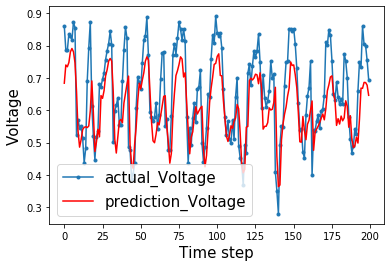

In [275]:
aa=[x for x in range(200)]
y=2
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

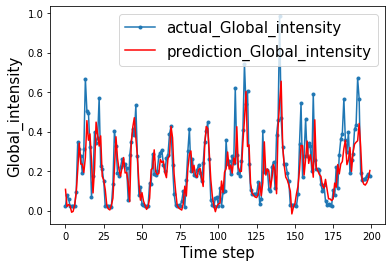

In [276]:
aa=[x for x in range(200)]
y=3
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

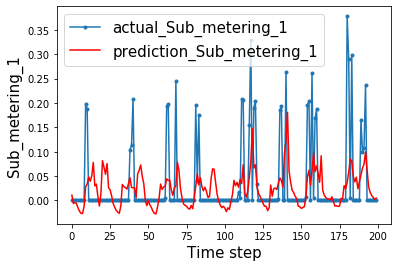

In [277]:
aa=[x for x in range(200)]
y=4
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

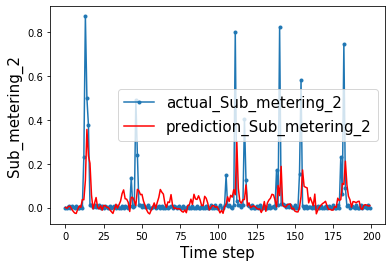

In [278]:
aa=[x for x in range(200)]
y=5
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

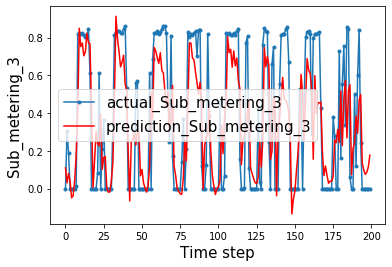

In [279]:
aa=[x for x in range(200)]
y=6
plt.plot(aa, test_y[:200,y], marker='.', label="actual_"+columnarray[y])
plt.plot(aa, yhat[:200,y], 'r', label="prediction_"+columnarray[y])
plt.ylabel(columnarray[y], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

# Forecasting 

In [27]:
#We are again scaling the entire data
values = df_resample.values 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [28]:
test_predictions=[] #this is to hold the forecasts
periods=20 #these many timesteps are forecasted. Therefore 20 hours is being forecasted
first_eval_batch=scaled[-timesteps:] #We used timesteps (30) previous data to predict one timestep. Therefore we take out
#that much amount of data as one batch. One batch predicts one timestep
current_batch=first_eval_batch.reshape(1,timesteps,n_features)

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    #Appending the forecasted values to our test_predictions
    test_predictions.append(current_pred)
    #In this step, we are removing the first time step in the batch we used to predict and adding the predicted values to the
    #last. Thus making it again timesteps amount of data to predict one more. This goes on a loop.
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [29]:
len(test_predictions) #forecasted timesteps

20

In [30]:
true_predictions=scaler.inverse_transform(test_predictions)
#converting back

In [31]:
forecast_index = pd.date_range(start='2010-11-26 22:00:00',periods=20,freq='H')
#start the date and time from where it ends in the data used for predictions

In [33]:
forecast=pd.DataFrame(columns=columnarray,index=forecast_index)
#adding columns

In [34]:
for index,x in enumerate(forecast.columns):
    forecast[x]=true_predictions[:,index]
    #filling the columns with the forecasted values

In [35]:
true_predictions[:,0]

array([0.83276068, 0.5007975 , 0.31060508, 0.25914781, 0.25111759,
       0.22986512, 0.21421758, 0.39420408, 1.13806312, 1.99326633,
       1.84165526, 1.59527275, 1.53772029, 1.49685696, 1.45476251,
       1.44374071, 1.48700193, 1.58488704, 1.72719754, 1.88538337])

In [40]:
forecast #forecasted values

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-11-26 22:00:00,0.832761,0.064454,243.459314,3.455185,0.127618,0.170343,2.803528
2010-11-26 23:00:00,0.500798,0.065717,244.647121,2.128726,-0.119388,0.092400,2.318367
2010-11-27 00:00:00,0.310605,0.069610,245.163811,1.390469,-0.249470,0.082312,1.915110
2010-11-27 01:00:00,0.259148,0.072560,245.388820,1.194390,-0.253896,0.139007,1.861133
2010-11-27 02:00:00,0.251118,0.074296,245.554276,1.152272,-0.231128,0.227616,1.905113
2010-11-27 03:00:00,0.229865,0.075035,245.754580,1.051635,-0.246945,0.294649,1.802697
2010-11-27 04:00:00,0.214218,0.075349,245.974508,0.987299,-0.283040,0.274628,1.560952
2010-11-27 05:00:00,0.394204,0.076547,245.806749,1.729100,-0.209496,0.145181,2.280799
2010-11-27 06:00:00,1.138063,0.080122,244.341590,4.720451,0.276245,0.214447,6.816578
2010-11-27 07:00:00,1.993266,0.085762,242.383285,8.154135,1.442870,0.785885,13.596149


In [41]:
df_resample

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


# Plotting Forecasted values

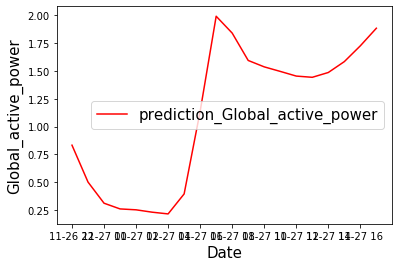

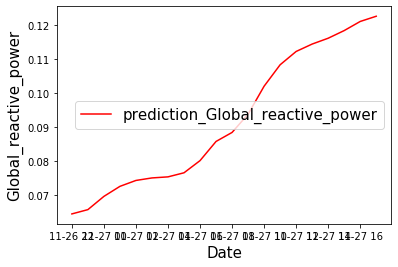

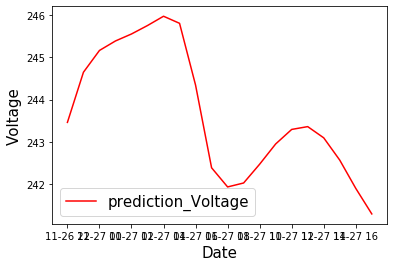

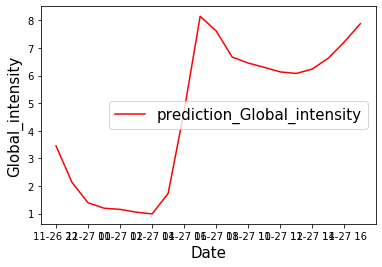

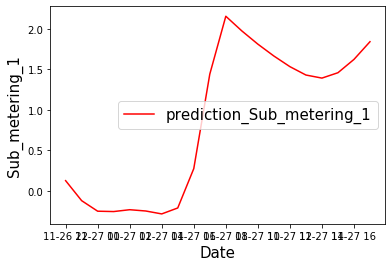

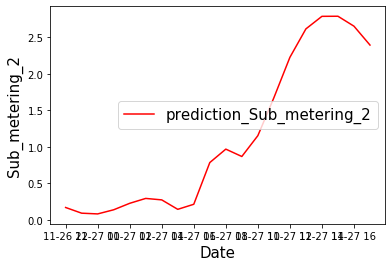

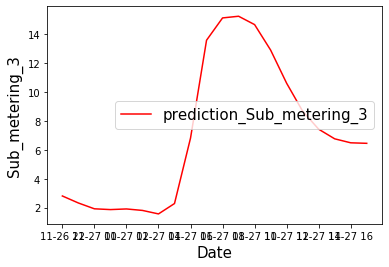

In [57]:
for x in range(n_features):
    
    plt.plot( forecast[columnarray[x]], 'r', label="prediction_"+columnarray[x])
    plt.ylabel(columnarray[x], size=15)
    plt.xlabel('Date', size=15)
    plt.legend(fontsize=15)
    plt.show()